<a href="https://colab.research.google.com/github/xiaoyi-627/A-Mixed-Effects-Model-Analysis/blob/main/MACE_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CONCLUSIONES**

El modelo AdaBoost indica que las variables más importantes a la hora de clasificar un MACE en el conjunto de datos utilizado son, por orden de importancia:

-  Score: 0.45100 CHARLSON. ( Índice de comorbilidad. )
-  Score: 0.20647 Cancer.
-  Score: 0.17205 DM. ( Diabetes mellitus. )
-  Score: 0.09905 MPOCAsmaBronq. ( EPOC + Asma + Deterioro cognitivo. )
-  Score: 0.07913 Demenciadetcognitiu. ( Demencia + Deterioro cognitivo. )
-  Score: 0.02204 EnfVascular. ( Enfermedad vascular. )
-  Score: 0.00180 CHADs. ( Escala CHADsVAsC -Anticoagular en FA- )
-  Score: 0.00003 Wells. ( Puntos en escala trombosis venosa. )
-  Score: 0.00003 Antiagregants.
-  Score: 0.00003 Anticoagulants.
-  Score: 0.00002 HTA. ( Hipertensión arterial. )

Llama poderosamente la atención que la variable FA no aparezca entre las más importantes a la hora de clasificar un MACE.

Debemos tener en cuenta, que no podemos ver todos los datos como una secuencia temporal que nos lleve a identificar una causa y su posible consecuencia; ya que por ejemplo, los datos de colesterol se tomaron dentro de los tres meses siguientes al diagnóstico positivo de FA, mientras que para aquellos diagnósticos negativos, esos mismos datos se tomaron al final del estudio.

Sería interesante disponer de todos los datos en función del tiempo, con tomas periódicas por ejemplo cada seis meses y analizar la evolución como si se tratara de una composición musical.

# Funciones auxiliares

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

def plotCorrelation(horizontalSize, verticalSize, correlation):
  plt.figure(figsize=(horizontalSize,verticalSize))
  sns.heatmap(correlation, annot=True, cmap=plt.cm.Reds)
  plt.show()


# Carga de datos originales


In [2]:
!gdown 1_SkndbIxgyP2OL9qR7G28MVYCys6DJbi

Downloading...
From: https://drive.google.com/uc?id=1_SkndbIxgyP2OL9qR7G28MVYCys6DJbi
To: /content/BaseDatosAnonim.xlsx
100% 9.43M/9.43M [00:00<00:00, 36.7MB/s]


In [3]:
import pandas as pd
df = pd.read_excel('BaseDatosAnonim.xlsx')

In [4]:
df.sample(10)

,DESC_UP,Comarca,CIP,EDAD,SEXO,PCC,RESIDENCIA,ATDOM,HTA,DM,...,CHARLSON,Wells,CONUT,PredictiuFAValor,PredictiuFARang,filter_$,RiskConut,RsikWells,COVID,Antiagregants
36142,AREA8,0,ANON_36136,79,0,0,0,0,1,0,...,0,0,0,7.6750,3,0,1,1,NaN,NaN
14693,AREA6,0,ANON_14690,87,0,0,0,0,0,0,...,2,1,2,8.7735,4,0,2,2,NaN,NaN
10365,AREA5,1,ANON_10363,71,0,0,1,0,0,0,...,2,1,0,6.9216,2,0,1,2,NaN,1.0
19269,AREA2,1,ANON_19264,90,0,0,1,0,1,0,...,0,0,0,8.4748,4,0,1,1,NaN,1.0
28523,AREA5,1,ANON_28517,70,0,0,1,0,1,1,...,1,0,0,7.6846,3,1,1,1,NaN,NaN
31442,AREA5,1,ANON_31436,79,0,0,1,0,1,0,...,0,0,0,9.3370,4,0,1,1,NaN,NaN
30848,AREA4,0,ANON_30842,85,1,0,1,0,1,1,...,2,0,0,8.0289,4,0,1,1,1.0,NaN
28197,AREA6,0,ANON_28191,81,1,0,0,0,1,0,...,0,0,0,8.2870,4,0,1,1,1.0,NaN
16031,AREA6,0,ANON_16027,70,0,0,2,0,1,0,...,0,0,1,7.8350,3,0,1,1,NaN,NaN
28945,AREA4,0,ANON_28939,91,1,0,0,0,0,1,...,6,1,0,8.9030,4,0,1,2,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40297 entries, 0 to 40296
Data columns (total 63 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DESC_UP              40297 non-null  object 
 1   Comarca              40297 non-null  int64  
 2   CIP                  40297 non-null  object 
 3   EDAD                 40297 non-null  int64  
 4   SEXO                 40297 non-null  int64  
 5   PCC                  40297 non-null  int64  
 6   RESIDENCIA           40297 non-null  int64  
 7   ATDOM                40297 non-null  int64  
 8   HTA                  40297 non-null  int64  
 9   DM                   40297 non-null  int64  
 10  Disli                40297 non-null  int64  
 11  CardIsquémica        40297 non-null  int64  
 12  InsCardiaca          40297 non-null  int64  
 13  ICTUSAIT             40297 non-null  int64  
 14  MACE                 40297 non-null  int64  
 15  EnfVascular          40297 non-null 

# Corrección de datos erróneos.

In [6]:

def updateValue(df, fieldToSearch, valueToSearch, fieldToUpdate, newValue):
  currentValue = df[(df[fieldToSearch] == valueToSearch)][fieldToUpdate].values[0]
  currentIndex = df[(df[fieldToSearch] == valueToSearch)][fieldToUpdate].keys()[0]
  df.loc[currentIndex,fieldToUpdate] = newValue
  updateValue = df.loc[currentIndex,fieldToUpdate]
  #updateValue = df[(df[fieldToSearch] == valueToSearch)][fieldToUpdate].values[0]
  print('El valor actual es', currentValue, 'y el nuevo valor es', updateValue)


updateValue(df, 'CIP', 'ANON_37629', 'ValorLinfo', 2.44)
updateValue(df, 'CIP', 'ANON_37628', 'ValorLinfo', 3.52)
updateValue(df, 'CIP', 'ANON_37627', 'ValorLinfo', 5.76)
updateValue(df, 'CIP', 'ANON_37626', 'ValorLinfo', 2.25)

updateValue(df, 'CIP', 'ANON_14682', 'PromigColest21', 92.2)


El valor actual es 2447.0 y el nuevo valor es 2.44
El valor actual es 2105.0 y el nuevo valor es 3.52
El valor actual es 281.43 y el nuevo valor es 5.76
El valor actual es 225.27 y el nuevo valor es 2.25
El valor actual es 922.0 y el nuevo valor es 92.2


# Sustitución de valores 0.0 y "nan".

#### Variable "Antiagregants"

In [7]:

print('La característica "Antiagregants" tiene como valores únicos:\n',
      df.Antiagregants.unique(),
      'y un total de', df.Antiagregants.isnull().sum(), 'valores "nan".',)

df.Antiagregants.fillna(0.0, inplace=True)

print('Una vez modificada la característica "Antiagregants" tiene como\n valores únicos:',
      df.Antiagregants.unique(),
      'y un total de', df.Antiagregants.isnull().sum(), 'valores "nan".',)


La característica "Antiagregants" tiene como valores únicos:
 [nan  1.] y un total de 34046 valores "nan".
Una vez modificada la característica "Antiagregants" tiene como
 valores únicos: [0. 1.] y un total de 0 valores "nan".


<ipython-input-7-4b00ee3bb4b2>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.Antiagregants.fillna(0.0, inplace=True)


#### Variable "COVID"

In [8]:

print('La característica "COVID" tiene como valores únicos:\n',
      df.COVID.unique(),
      'y un total de', df.COVID.isnull().sum(), 'valores "nan".',)

df.COVID.fillna(0.0, inplace=True)

print('Una vez modificada la característica "COVID" tiene como\n valores únicos:',
      df.COVID.unique(),
      'y un total de', df.COVID.isnull().sum(), 'valores "nan".',)


La característica "COVID" tiene como valores únicos:
 [nan  1.] y un total de 37106 valores "nan".
Una vez modificada la característica "COVID" tiene como
 valores únicos: [0. 1.] y un total de 0 valores "nan".


<ipython-input-8-020427c72729>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.COVID.fillna(0.0, inplace=True)


#### Variable "PromigColest21"

In [9]:
# *** Variable "PromigColest21"

#   El colesterol total considerado saludable para mujeres y hombres mayores
# de 20 años es de 200mg/dl.
#
#   Para los valores "nan" tomaremos el valor 200mg/dl.
#

print('Valores únicos', df.PromigColest21.unique())
print('Existen', df.PromigColest21[df.PromigColest21 == 0.0].count(), 'valores 0.0 en el conjunto de datos.')
print('Existen', df.PromigColest21.isna().sum(), 'valores "nan" en el conjunto de datos.')


Valores únicos [         nan 176.83333333 181.         ... 247.33333333 179.75
 199.9       ]
Existen 0 valores 0.0 en el conjunto de datos.
Existen 16218 valores "nan" en el conjunto de datos.


In [10]:

df.PromigColest21.fillna(200.0, inplace=True)


<ipython-input-10-75e7403482ea>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.PromigColest21.fillna(200.0, inplace=True)


#### Variable "ValorAlbSer"

In [11]:
# *** Variable "ValorAlbSer"
#
#   Se observan valores muy altos que hacen sospechar que son erróneos,
# o se encuentran en escalas distintas.
#
#   Los valores que no superan la decena parecen haber sido grabados
# en g/dl mientras que los que la superan sería en g/L.
#
#   Por otro lado los valores que superan la centena parece que
# fueron grabados sin la coma decimal en el lugar correcto.
#
#   Para los valores "nan" tomaremos el valor medio (4,4) del rango
# considerado normal y que es de 3,4 a 5,4 g/dl.

print('Valores únicos', df.ValorAlbSer.unique())
print('Existen', df.ValorAlbSer[df.ValorAlbSer == 0.0].count(), 'valores 0.0 en el conjunto de datos.')
print('Existen', df.ValorAlbSer.isna().sum(), 'valores "nan" en el conjunto de datos.')


Valores únicos [  2.1    3.62   2.7     nan   2.4    4.4    0.8    1.2    1.6    1.7
   2.9    4.05  32.     2.77   3.9    4.2    2.3    3.     2.8    3.09
   3.6    2.94   3.7    4.     4.31   1.8    2.5    3.2    4.3    3.1
   3.8    3.4    1.9    3.11   3.5    3.3   31.    33.    38.     2.2
   2.6    4.7    4.6    2.     3.27  30.    34.    39.     4.1    1.5
   3.96   4.5    4.58   2.25   3.23   3.07  28.    35.    36.     1.4
   4.92   4.66   3.47   4.26   4.8    3.54   3.49   4.45  24.    24.9
   4.03  47.     3.57   1.1    1.3   44.   431.     5.    42.     3.68
   4.75   3.71   3.97   4.9   37.     3.53   4.36   4.18   3.32   4.08
   4.19   4.06   4.52   3.18   3.39   3.66   4.44   3.29   3.92  41.
  21.    27.   391.     4.82  40.     4.42   3.48   3.86   2.57   3.76
   2.33   4.34   4.24   4.76   4.93   5.2   22.    25.     4.73   4.51
   4.96   3.78   4.12   4.37   3.25   4.29   4.39   4.49   4.53   4.38
   4.47   4.63   3.35   5.25   4.54   3.94   4.15   3.45   4.27   2.42

In [12]:

df.ValorAlbSer.fillna(4.4, inplace=True)


<ipython-input-12-ed1796555f4d>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.ValorAlbSer.fillna(4.4, inplace=True)


#### Variable "ValorDimer"

In [13]:
# *** Variable "ValorDimer"
#
#   El valor de referencia del dímero D en la sangre es de hasta 0,500 µd/mL
# o 500 ng/mL.
#
#   La visualización del conjunto de datos nos hace suponer que los datos están
# en ng/ml.
#
#   Para los valores "nan" tomaremos el valor de referencia 500 ng/ml
#

print('Valores únicos', df.ValorDimer.unique())
print('Existen', df.ValorDimer[df.ValorDimer == 0.0].count(), 'valores 0.0 en el conjunto de datos.')
print('Existen', df.ValorDimer.isna().sum(), 'valores "nan" en el conjunto de datos.')


Valores únicos [  nan 4873. 1901. ... 1773. 1854. 3195.]
Existen 0 valores 0.0 en el conjunto de datos.
Existen 38707 valores "nan" en el conjunto de datos.


In [14]:

df.ValorDimer.fillna(500., inplace=True)


<ipython-input-14-a2e168a188f1>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.ValorDimer.fillna(500., inplace=True)


#### Variable "ValorLinfo"

In [15]:
# *** Variable "ValorLinfo"
#
#  Su valor se calcula por cada mililitro de sangre, el rango de normalidad
# de los linfocitos se encuentra entre 1300 y 4000 células por mililitro.
#
#  La visualización del conjunto de datos nos hace suponer que los datos están
# en millones/L.
#   Aun así aparecen valores sospechosamente altos.
#
#  Así mismo aparecen el valor 0 y "nan" que son evidentemente erróneos.
#
#  Se sustituyen los valores 0 y "nan" por la media del rango normal 2,65x10e0.
#

print('Valores únicos', df.ValorLinfo.unique())
print('Existen', df.ValorLinfo[df.ValorLinfo == 0.0].count(), 'valores 0.0 en el conjunto de datos.')
print('Existen', df.ValorLinfo.isna().sum(), 'valores "nan" en el conjunto de datos.')


Valores únicos [0.0000e+00 4.0000e-02 5.0000e-02 9.0000e-02 1.0000e-01 1.1000e-01
 1.4000e-01 1.5000e-01 1.7000e-01 1.8000e-01 1.9000e-01 2.0000e-01
 2.1000e-01 2.2000e-01 2.3000e-01 2.4000e-01 2.5000e-01 2.6000e-01
 2.7000e-01 2.9000e-01 3.0000e-01 3.1000e-01 3.2000e-01 3.3000e-01
 3.4000e-01 3.5000e-01 3.6000e-01 3.7000e-01 3.8000e-01 3.9000e-01
 4.0000e-01 4.1000e-01 4.2000e-01 4.3000e-01 4.4000e-01 4.5000e-01
 4.6000e-01 4.7000e-01 4.8000e-01 4.9000e-01 5.0000e-01 5.1000e-01
 5.2000e-01 5.3000e-01 5.4000e-01 5.5000e-01 5.6000e-01 5.7000e-01
 5.8000e-01 5.9000e-01 6.0000e-01 6.1000e-01 6.2000e-01 6.3000e-01
 6.4000e-01 6.5000e-01 6.6000e-01 6.7000e-01 6.8000e-01 6.9000e-01
 7.0000e-01 7.1000e-01 7.2000e-01 7.3000e-01 7.4000e-01 7.5000e-01
 7.6000e-01 7.7000e-01 7.8000e-01 7.9000e-01 8.0000e-01 8.1000e-01
 8.2000e-01 8.3000e-01 8.4000e-01 8.5000e-01 8.6000e-01 8.7000e-01
 8.8000e-01 8.9000e-01 9.0000e-01 9.1000e-01 9.2000e-01 9.3000e-01
 9.4000e-01 9.5000e-01 9.6000e-01 9.7000e-01 9.

In [16]:

df.ValorLinfo.replace({0.0: 2.65}, inplace=True)
df.ValorLinfo.fillna(2.65, inplace=True)


<ipython-input-16-3dc792356823>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.ValorLinfo.replace({0.0: 2.65}, inplace=True)
<ipython-input-16-3dc792356823>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

#### Variable "ValorFGlomerular"

In [17]:
# *** Variable "ValorDimer"
#
#   El ValorFGlomerular se informa en mililitros/minuto/1,73m2 (mL/min/1,73m2).
#   Un resultado normal de ValorFGlomerular debe ser superior a 90 mL/min/1,73m2.
#
#   Para los valores "nan" tomaremos el valor 100 ml/min.
#

print('Valores únicos', df.ValorFGlomerular.unique())
print('Existen', df.ValorFGlomerular[df.ValorFGlomerular == 0.0].count(), 'valores 0.0 en el conjunto de datos.')
print('Existen', df.ValorFGlomerular.isna().sum(), 'valores "nan" en el conjunto de datos.')


Valores únicos [        nan 94.         21.1        ...  6.4        13.1
 48.12496057]
Existen 0 valores 0.0 en el conjunto de datos.
Existen 14556 valores "nan" en el conjunto de datos.


In [18]:

df.ValorFGlomerular.fillna(100., inplace=True)


<ipython-input-18-2a0c04b9ad6c>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.ValorFGlomerular.fillna(100., inplace=True)


#### Variable "ValorIMC"

In [19]:
# *** Variable "ValorIMC"
#
#   Si el IMC está entre 18.5 y 24.9, se encuentra dentro del rango de peso
# normal o saludable.
#   Si el IMC está entre 25.0 y 29.9, se encuentra dentro del rango de sobrepeso.
#   Si el IMC es 30.0 o superior, se encuentra dentro del rango de obesidad.
#
#   Para los valores cero y "nan" tomaremos el 24.9.
#

print('Valores únicos', df.ValorIMC.unique())
print('Existen', df.ValorIMC[df.ValorIMC == 0.0].count(), 'valores 0.0 en el conjunto de datos.')
print('Existen', df.ValorIMC.isna().sum(), 'valores "nan" en el conjunto de datos.')


Valores únicos [25.92 25.85 23.2  ... 59.33 65.   83.25]
Existen 22 valores 0.0 en el conjunto de datos.
Existen 1374 valores "nan" en el conjunto de datos.


In [20]:

df.ValorIMC.replace({0.0: 24.9}, inplace=True)
df.ValorIMC.fillna(24.9, inplace=True)


<ipython-input-20-9d536ec332c0>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.ValorIMC.replace({0.0: 24.9}, inplace=True)
<ipython-input-20-9d536ec332c0>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

#### Variable "ValorPfeiffer"

In [21]:
# *** Variable "ValorPfeiffer"
#
#   La escala Pfeiffer consta de diez preguntas, por lo que es de rápida
# aplicación.
#
#   Estas son un ejemplo de las cuestiones que lo forman:
#
#   1.-  ¿Qué día es hoy? (Mes, día y año).
#   2.-  ¿Qué día de la semana es hoy?
#   3.-  ¿Cómo se llama este sitio?
#   4.-  ¿Cuál es su número de teléfono? (Si no lo hay, la dirección de la calle).
#   5.-  ¿Cuántos años tiene?
#   6.-  ¿Cuánto nació?
#   7.-  ¿Quién es el actual presidente del país?
#   8.-  ¿Quién fue el anterior presidente?
#   9.-  Dígame el primer apellido de su madre.
#  10.-  Empezando desde 20, vaya restando de 3 en 3 sucesivamente.
#
#   Para que una respuesta sea considerada como correcta, serán tenidos en
# cuenta los siguientes criterios de evaluación:
#
#   1.- Se considera correcta solo si dice el día, mes y año exacto.
#   2.- Se marcará como correcta solo dice el día.
#   3.- La puntuación será aceptada como válida si describe el nombre
#       de la residencia, lugar, casa, hospital, etc.
#   4.- Existen dos posibilidades de darla como correcta: si se confirma
#       el número con algún familiar o si repite el mismo número dos veces.
#       Lo mismo ocurre con la dirección.
#   5.- Será correcta si corresponde con la fecha de nacimiento.
#   6.- Se considera válida si aporta el día, mes y el año exacto.
#   7.- Bastará con el apellido del presidente.
#   8.- Al igual que la anterior, será suficiente solo con el apellido.
#   9.- La verificación de la respuesta podrá verse en la ficha clínica,
#       pero deberá ser correcta para puntual como válida.
#  10.- Puntuará como correcta si es capaz de decir toda la serie
#       completa: 20-17-14-11-8-5-2.
#
#   Un error equivale a un punto.
#
#    Puntuación máxima: 8 errores.
#    0-2 errores: normal.
#    3-4 errores: leve deterioro cognitivo.
#    5-7 errores: modero deterioro cognitivo, patológico.
#    8-10 errores: importante deterioro cognitivo.
#
#   Si el sujeto no tiene estudios o estudios básicos, se aceptará un
# error más. Si tiene estudios superiores, un error menos.
#
#   Si el IMC está entre 18.5 y 24.9, se encuentra dentro del rango de peso
# normal o saludable.
#   Si el IMC está entre 25.0 y 29.9, se encuentra dentro del rango de sobrepeso.
#   Si el IMC es 30.0 o superior, se encuentra dentro del rango de obesidad.
#
#   Para el valor "nan" tomaremos el 2.
#

print('Valores únicos', df.ValorPfeiffer.unique())
print('Existen', df.ValorPfeiffer[df.ValorPfeiffer == 0.0].count(), 'valores 0.0 en el conjunto de datos.')
print('Existen', df.ValorPfeiffer.isna().sum(), 'valores "nan" en el conjunto de datos.')


Valores únicos [ nan  0.   3.   7.   6.   8.  10.   4.   1.   2.   5.   9.   7.5  9.5
  6.5  5.5  3.5  2.5]
Existen 1553 valores 0.0 en el conjunto de datos.
Existen 34591 valores "nan" en el conjunto de datos.


In [22]:

df.ValorPfeiffer.fillna(1.0, inplace=True)


<ipython-input-22-89a38870984c>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.ValorPfeiffer.fillna(1.0, inplace=True)


#### Variable "ValorproBNP"

In [23]:
# *** Variable "ValorproBNP"
#
#   https://www.revespcardiol.org/es-biomarcadores-insuficiencia-cardiaca-aguda-articulo-S0300893215001281
#
#   Anteniendonos a los datos de la web de referencia le asignamos 675 a los
# valores "nan".
#

print('Valores únicos', df.ValorproBNP.unique())
print('Existen', df.ValorproBNP[df.ValorproBNP == 0.0].count(), 'valores 0.0 en el conjunto de datos.')
print('Existen', df.ValorproBNP.isna().sum(), 'valores "nan" en el conjunto de datos.')


Valores únicos [  nan 4300. 1550. 6934. 1085.  800. 3214.  888. 1653. 1490. 1539.  855.
  532.]
Existen 0 valores 0.0 en el conjunto de datos.
Existen 40285 valores "nan" en el conjunto de datos.


In [24]:

df.ValorproBNP.fillna(675.0, inplace=True)


<ipython-input-24-6ce84bc2eb11>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.ValorproBNP.fillna(675.0, inplace=True)


# Particionado de los datos por clases.
- Geográfico
- Identidad
- Objetivo
- Diagnósticos
- Tratamientos
- Pruebas
- Acción
- Irrelevante




In [25]:
descripcion = {

    # Geográfico
    'Comarca': 'Límite geográfico.',
    'DESC_UP': 'Centro de salud.',

    # Identidad
    'CIP': 'Código de identificación del paciente.',
    'EDAD': 'Edad del paciente.',
    'SEXO': 'Sexo del paciente.',

    # Objetivo
    'MACE': 'Eventos cardiovasculares mayores adversos.',

    # Diagnósticos
    'AltHepática': 'Enfermedad hepática.',
    'Cancer': 'Cancer.',
    'CardIsquémica': 'Cardiopatía isquémica.', # Dentro MACE (Angina de pecho o Infarto).
    'Chron': 'Enfermedades inflamatorias (Crohn + Colitis).',
    'COVID': 'COVID',
    'Demenciadetcognitiu': 'Demencia + Deterioro cognitivo.',
    'Disli': 'Dislipemia.',
    'DM': 'Diabetes mellitus.',
    'EnfVascular': 'Enfermedad vascular.',
    'EsgEEII': 'Esguinces en miembros inferiores.',
    'FA': 'Fibrilación auricular.', # Hipótesis
    'FLEB': 'Flebitis.',
    'fraEEII': 'Fracturas óseas de miembros inferiores.',
    'HTA': 'Hipertensión arterial.',
    'ICTUSAIT': 'Ictus + AIT (Accidente Isquémico Transitorio).', # Dentro de MACE
    'InsCardiaca': 'Insuficiencia cardiaca.', # Dentro de MACE
    'Irenal': 'Insuficiencia renal.',
    'MPOCAsmaBronq': 'EPOC + Asma + Bronquitis Crónica.',
    'PCC': 'Pacientes Crónico Complejo',
    'SAHS': 'Síndrome Apnea Hipopnea del Sueño (roncar).',
    'Situacio': 'Éxitus.',
    'TEP': 'Tromboembolismo Pulmonar.',
    'Tiroides': 'Tiroides.',
    'Trombo': 'Trombosis.',
    'Varius': 'Varices.',

    # Tratamientos
    'Antiagregants': 'Antiagregantes (fármaco).',
    'Anticoagulants': 'Anticoagulantes (clásicos)',
    'AntiVitK': 'Tipo de anticoagulantes',
    'Estatines': 'Estatinas (tratamiento colesterol)',
    'NACO': 'Nuevos anticoagulantes (otro tipo)',
    'NumFàrmacs': 'Número de fármacos.',
    'TramFarmacs': 'Fármacos nuevos añadidos',

    # Pruebas
    'CHADs': 'Escala CHADsVAsC (Anticoagular en FA).',
    'CHARLSON': 'Índice de comorbilidad.',
    'CONUT': 'Puntos en escala riesgo de desnutrición.',
    'ECG': 'Electrocardiograma.',
    'PredictiuFARang': 'Clasificación en quartiles según el riesgo.',
    'PredictiuFAValor': 'Valor predictivo de riesgo de FA según datos.',
    'PromigColest21': 'Nivel de colesterol.',
    'RiskConut': 'Clasificación dentro riesgo en escala CONUT.',
    'RsikWells': 'Clasificación dentro riesgo en escala Wells.',
    'ValorAlbSer': 'Niveles de albúmina.',
    'ValorDimer': 'Dímero D (marcador trombosis).',
    'ValorLinfo': 'Niveles de linfocitos.',
    'ValorFGlomerular': 'Filtrado glomerular.', # Relacionado con enfermedad renal.
    'ValorFrCard': 'Frecuencia cardiaca.',
    'ValorIMC': 'Índice de masa corporal (IMC).',
    'ValorPes': 'Peso (kg).',
    'ValorPfeiffer': 'Escala Deterioro Cognitivo.',
    'ValorproBNP': 'proBNP (marcador cardiaco)',
    'Wells': 'Puntos en escala trombosis venosa.',

    # Acción
    'ATDOM': 'Atención a domicilio.',
    'RESIDENCIA': 'Estancia en residencia (0,1,2)',
    'TSEGUIM': 'Tiempo de seguimiento (meses)',
    'VisitesHospital': 'Visitas a hospital.',

    # Irrelevante
    'filter_$': 'Filtro aplicado para la extracción de datos.',
    'Insti_RRGG': 'Situación institucional.'
}

geographic = ['Comarca', 'DESC_UP']

identification = ['CIP', 'EDAD', 'SEXO']

diagnostic = ['AltHepática', 'Cancer', 'CardIsquémica', 'Chron',  'COVID',
             'Demenciadetcognitiu', 'Disli', 'DM', 'EnfVascular', 'EsgEEII',
             'FA','FLEB', 'fraEEII', 'HTA', 'ICTUSAIT', 'InsCardiaca',
             'Irenal', 'MPOCAsmaBronq', 'PCC', 'SAHS', 'Situacio',
             'TEP', 'Tiroides', 'Trombo', 'Varius']

treatment = ['Antiagregants', 'Anticoagulants', 'AntiVitK', 'Estatines',
             'NACO', 'NumFàrmacs', 'TramFarmacs']

test = ['CHADs', 'CHARLSON', 'CONUT', 'ECG', 'PredictiuFARang',
        'PredictiuFAValor', 'PromigColest21', 'RiskConut', 'RsikWells',
        'ValorAlbSer', 'ValorDimer',  'ValorLinfo', 'ValorFGlomerular',
        'ValorFrCard', 'ValorIMC', 'ValorPes', 'ValorPfeiffer',
        'ValorproBNP', 'Wells']

action = ['ATDOM', 'RESIDENCIA', 'TSEGUIM', 'VisitesHospital']

target = ['MACE']

irrelevant = ['filter_$', 'Insti_RRGG']


# Correlaciones


### Correlación de los diagnósticos con MACE.

In [26]:

print('Las características:\n\n\
\t"CardIsquémica"\n\
\t"ICTUSAIT"\n\
\t"InsCardiaca"\n\n\
están contenidas en la característica "MACE",\n\
luego solamente se tendrá en cuenta esta última.\n')

print('Hay un total de ',
      df.MACE[(df.MACE == 1) & ( (df.CardIsquémica == 1) | (df.ICTUSAIT == 1) | (df.InsCardiaca == 1) )   ].count(),
      '"MACE" igual a 1 con "CardIsquémica" igual a 1 o "ICTUSAIT" igual a 1 o "InsCardiaca" igual a 1.')

print('Hay un total de ',
      df.MACE[(df.MACE == 0) & ( (df.CardIsquémica == 1) | (df.ICTUSAIT == 1) | (df.InsCardiaca == 1) )   ].count(),

      '"MACE" igual a 0 con "CardIsquémica" igual a 1 o "ICTUSAIT" igual a 1 o "InsCardiaca" igual a 1.')


Las características:

	"CardIsquémica"
	"ICTUSAIT"
	"InsCardiaca"

están contenidas en la característica "MACE",
luego solamente se tendrá en cuenta esta última.

Hay un total de  5824 "MACE" igual a 1 con "CardIsquémica" igual a 1 o "ICTUSAIT" igual a 1 o "InsCardiaca" igual a 1.
Hay un total de  0 "MACE" igual a 0 con "CardIsquémica" igual a 1 o "ICTUSAIT" igual a 1 o "InsCardiaca" igual a 1.


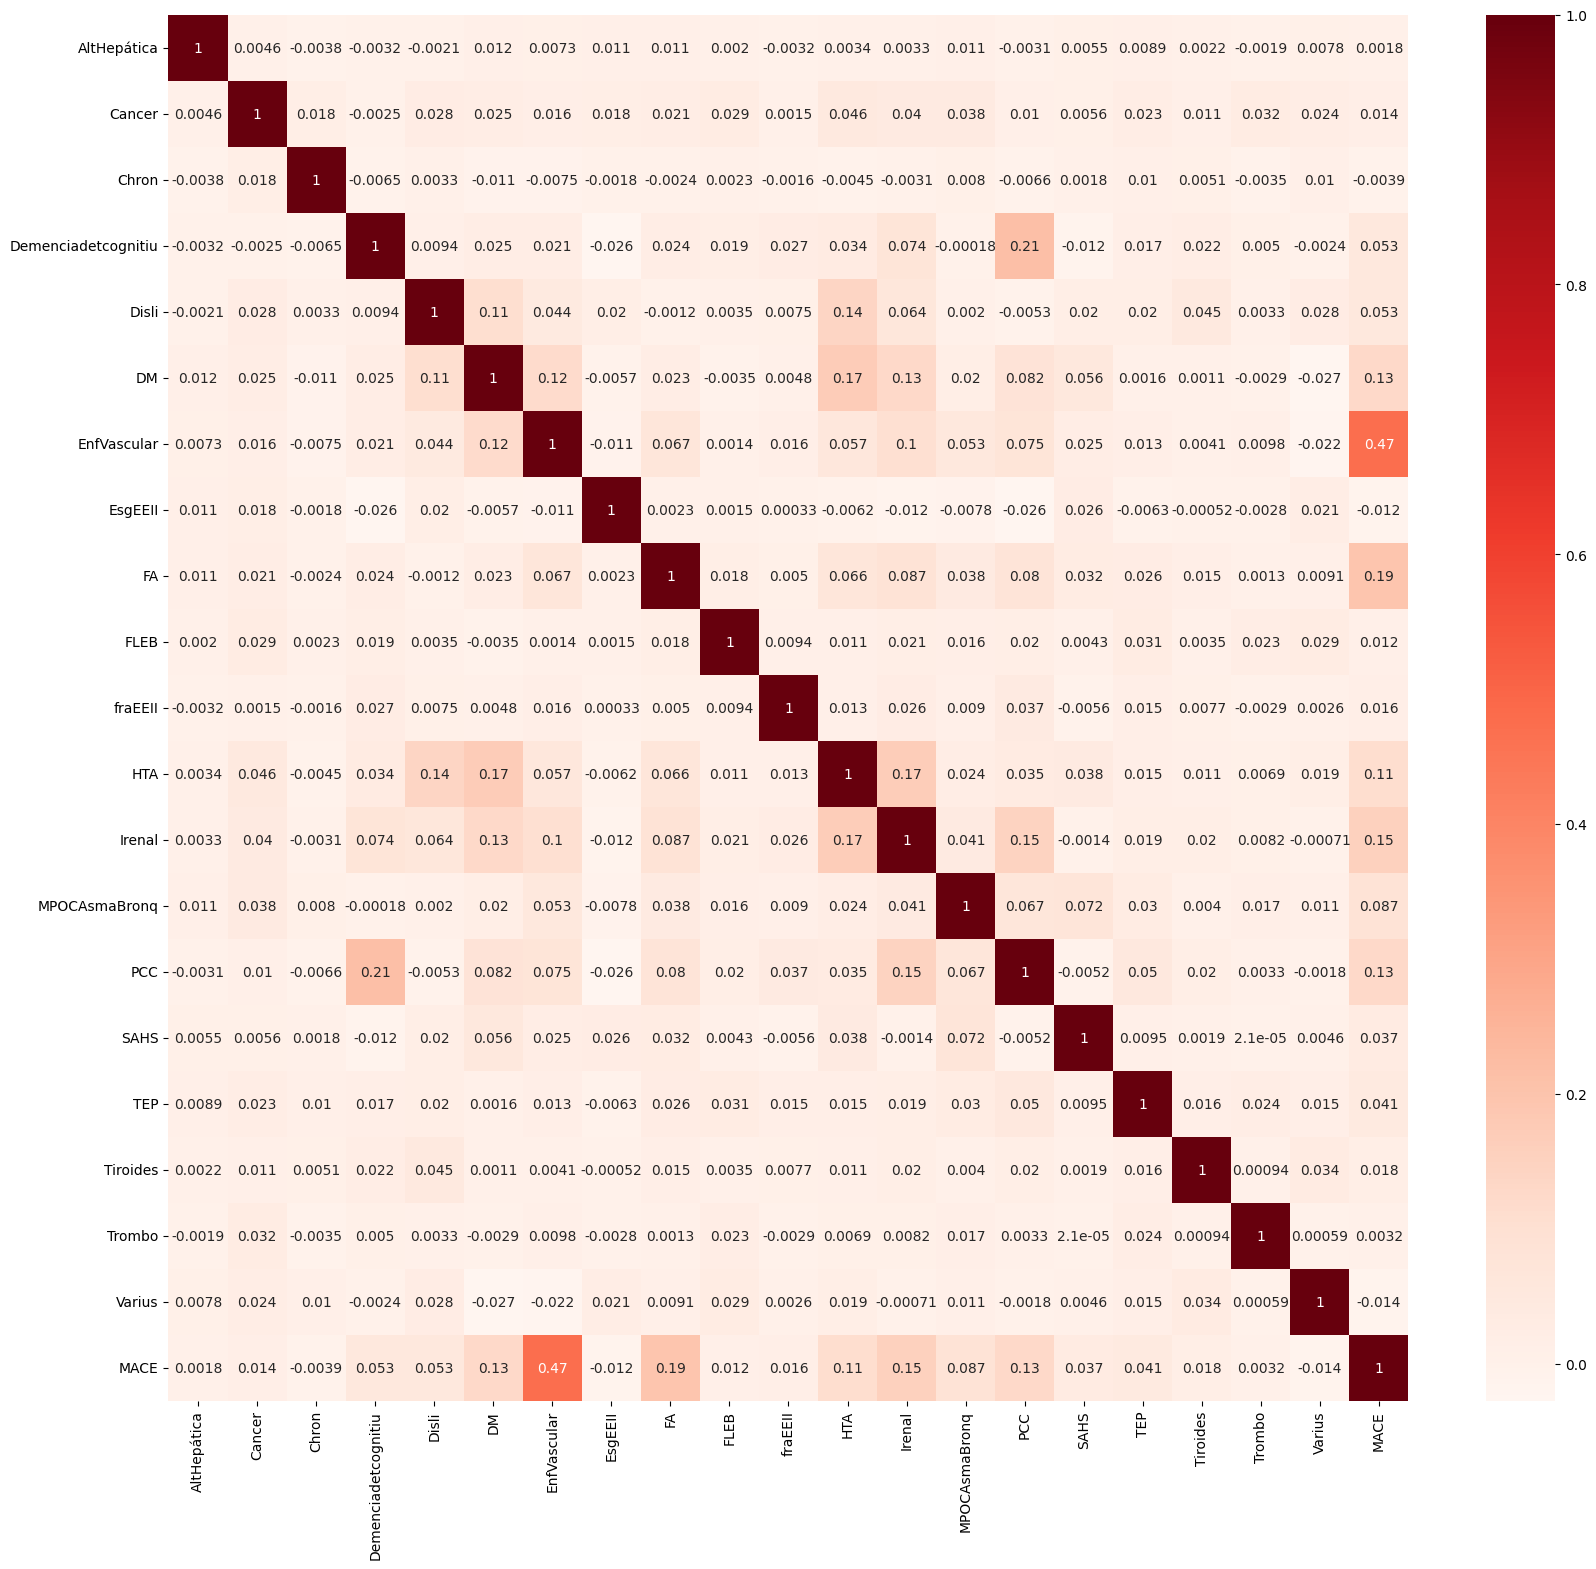

In [ ]:

diagnostics = diagnostic.copy()

# Se eliminan las variables:
#
# 'COVID'          - El investigador nos informa de que esta variable es
#                  irrelevante para el estudio.
#
# 'Situacio'       - El investigador nos informa de que esta variable (muerte)
#                  es irrelevante para el estudio.
#
# 'CardIsquémica'  - Su valor está contenido en la variable "MACE".
#
# 'ICTUSAIT'       - Su valor está contenido en la variable "MACE".
#
# 'InsCardiaca'    - Su valor está contenido en la variable "MACE".
#

featuresToRemoveFromDiagnosticList = ['COVID',
                                    'Situacio',
                                    'CardIsquémica',
                                    'ICTUSAIT',
                                    'InsCardiaca']

for item in featuresToRemoveFromDiagnosticList:
  diagnostics.remove(item)

# Añadimos "MACE" para visualizar la correlación con los diagnósticos.
diagnostics.append('MACE')

df_diagnostics = df[diagnostics]

plotCorrelation(20, 18, df_diagnostics.corr())


### Correlación de las pruebas y MACE.

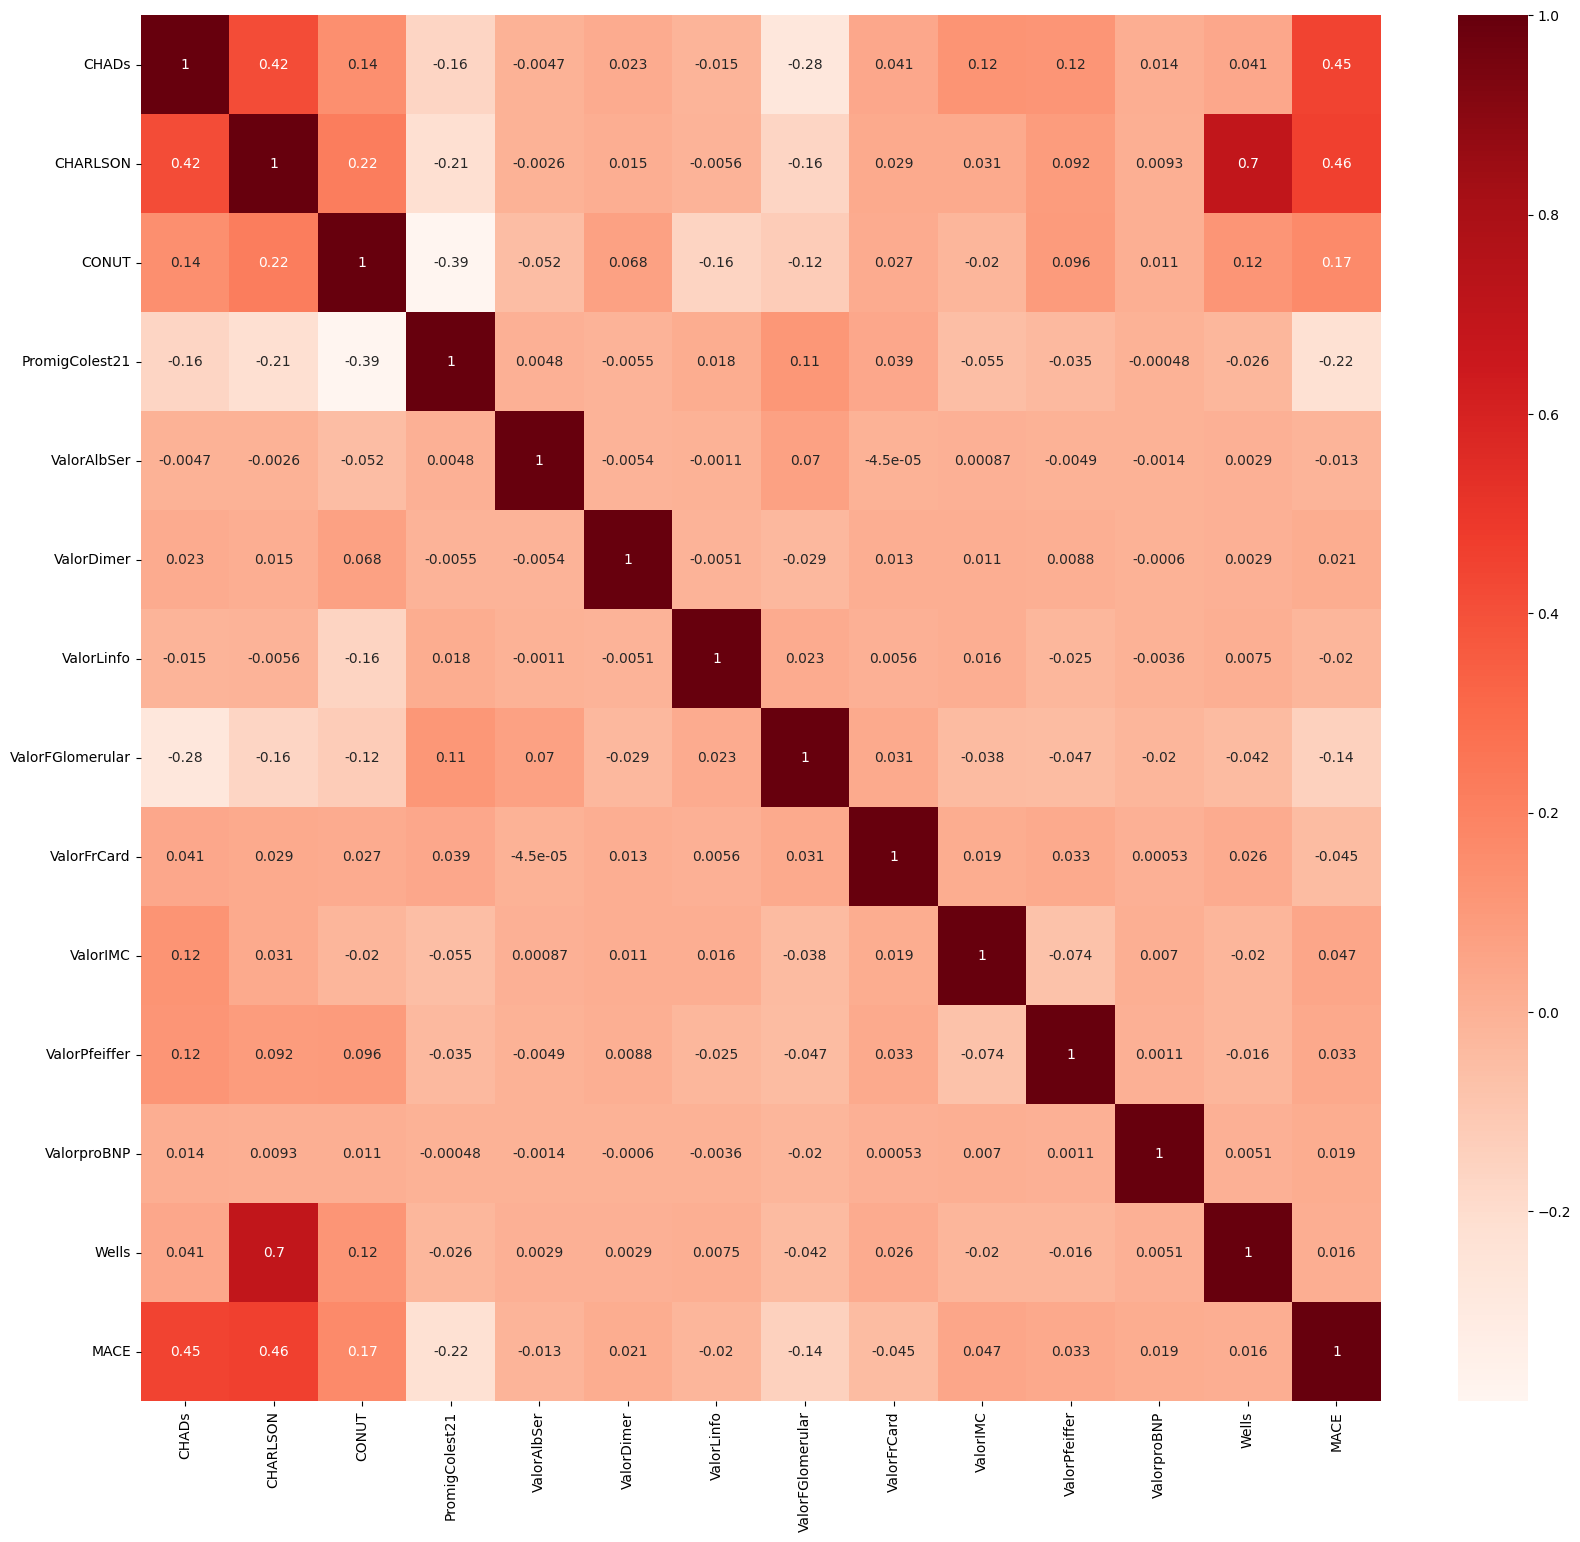

In [ ]:

tests = test.copy()

# Se eliminan las variables:
#
# 'ECG'           - El investigador nos informa de que esta variable no es
#                   necesario tenerla en cuenta ya que solamente no informa
#                   de si se la ha realizado un electricardiograma o no.
#
# 'RsikWells'    - El investigador no informa de que no es necesario tener
#                  en cuenta esta variable y la variable "Well" a la vez,
#                  con una de ellas es suficiente.
#
# 'RsikConut'    - El investigador no informa de que no es necesario tener
#                  en cuenta esta variable y la variable "CONUT" a la vez,
#                  con una de ellas es suficiente.
#
# 'PredictiuFARang'  - El investigador no informa de que no es necesario tener
#                    en cuenta esta variable y la variable "CHADS" a la vez,
#                    con una de ellas es suficiente.
#
# 'PredictiuFAValor' - El investigador no informa de que no es necesario tener
#                    en cuenta esta variable y la variable "CHADS" a la vez,
#                    con una de ellas es suficiente.
#
# 'ValorPes'     - El investigador no informa de que no es necesario tener
#                  en cuenta esta variable y la variable "ValorIMC" a la vez,
#                  con una de ellas es suficiente.

featuresToRemoveFromTestList = ['ECG',
                                'RsikWells',
                                'RiskConut',
                                'PredictiuFARang',
                                'PredictiuFAValor',
                                'ValorPes']

for item in featuresToRemoveFromTestList:
  tests.remove(item)

# Añadimos "MACE" para visualizar la correlación con las prueba médicas.
tests.append('MACE')

df_tests = df[tests]

plotCorrelation(20, 18, df_tests.corr())


### Correlación de los tratamientos con MACE.

In [ ]:

print('Las características:\n\n\t"AntiVitK" (Tipo de anticoagulante)\n\t\
"NACO" (Nuevos anticoagulantes)\n\n\
están contenidas en la característica "Anticoagulants",\n\
luego solamente se tendrá en cuenta esta última.\n')

#print('Hay un total de ', df.Anticoagulants[df.Anticoagulants == 1].count(), 'sujetos que toman anticoagulantes.')
print('Hay un total de ',
      df.Anticoagulants[(df.Anticoagulants == 1) & (df.AntiVitK ==1)].count(),
      '"Anticuagulants" igual a 1 y "AntiVitK" igual a 1.')
print('Hay un total de ',
      df.Anticoagulants[(df.Anticoagulants == 0) &(df.AntiVitK ==1)].count(),
      '"Anticuagulants" igual a 0 y "AntiVitK" igual a 1.')
print('')
print('Hay un total de ',
      df.Anticoagulants[(df.Anticoagulants == 1) &(df.NACO ==1)].count(),
      '"Anticuagulants" igual a 1 y "NACO" igual a 1.')
print('Hay un total de ',
      df.Anticoagulants[(df.Anticoagulants == 0) &(df.NACO ==1)].count(),
      '"Anticuagulants" igual a 0 y "NACO" igual a 1.')


Las características:

	"AntiVitK" (Tipo de anticoagulante)
	"NACO" (Nuevos anticoagulantes)

están contenidas en la característica "Anticoagulants",
luego solamente se tendrá en cuenta esta última.

Hay un total de  1698 "Anticuagulants" igual a 1 y "AntiVitK" igual a 1.
Hay un total de  0 "Anticuagulants" igual a 0 y "AntiVitK" igual a 1.

Hay un total de  1288 "Anticuagulants" igual a 1 y "NACO" igual a 1.
Hay un total de  0 "Anticuagulants" igual a 0 y "NACO" igual a 1.


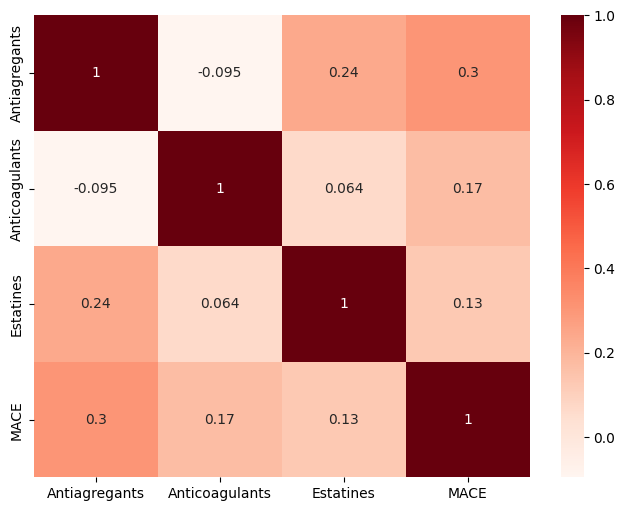

In [ ]:

treatments = treatment.copy()

# Se eliminan las variables:
#
# 'NumFàrmacs'    - Solamente contabiliza el número de farmacos con los que
#                   está siendo tratado el sujeto. Carece de valor ya que los
#                   fármacos constan en sus propias variables.
#
# 'TramFarmacs'   - Solamente contabiliza si el sujeto está siendo tratado con
#                   nuevos fármacos y dichos fármacos constan en sus propias
#                   variables.
#
# 'AntiVitk'      - Su valor está contenido en la variable "Anticoagulants".
#
# 'NACO'          - Su valor está contenido en la variable "Anticoagulants".
#

featuresToRemoveFromTreatmentList = ['NumFàrmacs',
                                    'TramFarmacs',
                                    'AntiVitK',
                                    'NACO']

for item in featuresToRemoveFromTreatmentList:
  treatments.remove(item)

# Añadimos "MACE" para visualizar la correlación con los tratamientos.
treatments.append('MACE')

df_treatments = df[treatments]

plotCorrelation(8, 6, df_treatments.corr())


# Aplicación de modelos de clasificación.

In [ ]:

from sklearn.model_selection import train_test_split

featuresList = (diagnostic + test + treatment)
featuresToRemove = (featuresToRemoveFromDiagnosticList +
                    featuresToRemoveFromTestList +
                    featuresToRemoveFromTreatmentList)

for item in featuresToRemove:
  featuresList.remove(item)

X = df[featuresList]
y = df[target[0]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


#### Random Forest

In [ ]:

from sklearn.ensemble import RandomForestClassifier

ramdomForestModel = RandomForestClassifier(n_estimators=100)
ramdomForestModel.fit(X_train, y_train)
y_pred = ramdomForestModel.predict(X_test)


In [ ]:

from sklearn import metrics

ramdomForestModelAccuracy = metrics.accuracy_score(y_test, y_pred)

print("Random Forest Accuracy:", ramdomForestModelAccuracy)


Random Forest Accuracy: 0.9678246484698098


In [ ]:

from sklearn.metrics import confusion_matrix

confusion_matrix(y_pred, y_test)


array([[10216,   271],
       [  118,  1485]])

#### Extra Trees

In [ ]:

from sklearn.ensemble import ExtraTreesClassifier

extraTreesModel = ExtraTreesClassifier(n_estimators=100)
extraTreesModel.fit(X_train,y_train)
y_pred=extraTreesModel.predict(X_test)


In [ ]:

from sklearn import metrics

extraTreesModelAccuracy = metrics.accuracy_score(y_test, y_pred)

print("Random Forest Accuracy:", ramdomForestModelAccuracy)
print("Extra Trees Accuracy:", extraTreesModelAccuracy)


Random Forest Accuracy: 0.9678246484698098
Extra Trees Accuracy: 0.9882547559966914


In [ ]:

from sklearn.metrics import confusion_matrix

confusion_matrix(y_pred, y_test)


array([[10255,    63],
       [   79,  1693]])

#### AdaBoost **"Presenta los mejores resultados"**

In [ ]:

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

adaBoostModel = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=100
)
adaBoostModel.fit(X_train, y_train)
y_pred = adaBoostModel.predict(X_test)


In [ ]:

from sklearn import metrics

adaBoostModelAccuracy = metrics.accuracy_score(y_test, y_pred)

print("Random Forest Accuracy:", ramdomForestModelAccuracy)
print("Extra Trees Accuracy:", extraTreesModelAccuracy)
print("AdaBoost Accuracy:", adaBoostModelAccuracy)

Random Forest Accuracy: 0.9678246484698098
Extra Trees Accuracy: 0.9882547559966914
AdaBoost Accuracy: 0.9999172870140612


In [ ]:
from sklearn.metrics import recall_score
revacll = recall_score(y_test, y_pred)
print("AdaBoost Recall:", adaBoostModelAccuracy)

AdaBoost Recall: 0.9999172870140612


In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)
print("AdaBoost F1:", f1)

AdaBoost F1: 0.9997153430116709


In [ ]:

from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, y_pred)
confusion

array([[10333,     1],
       [    0,  1756]])

[Text(0, 0.5, 'NO MACE'), Text(0, 1.5, 'MACE')]

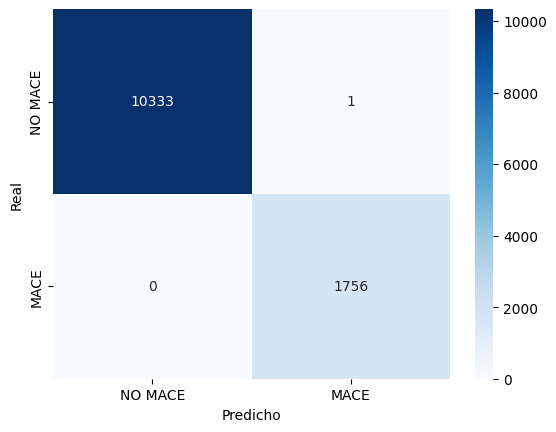

In [ ]:
import seaborn as sns
fig, ax = plt.subplots()
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g')
ax.set_xlabel('Predicho')
ax.set_ylabel('Real')
ax.set_xticklabels(['NO MACE', 'MACE'])
ax.set_yticklabels(['NO MACE', 'MACE'])

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

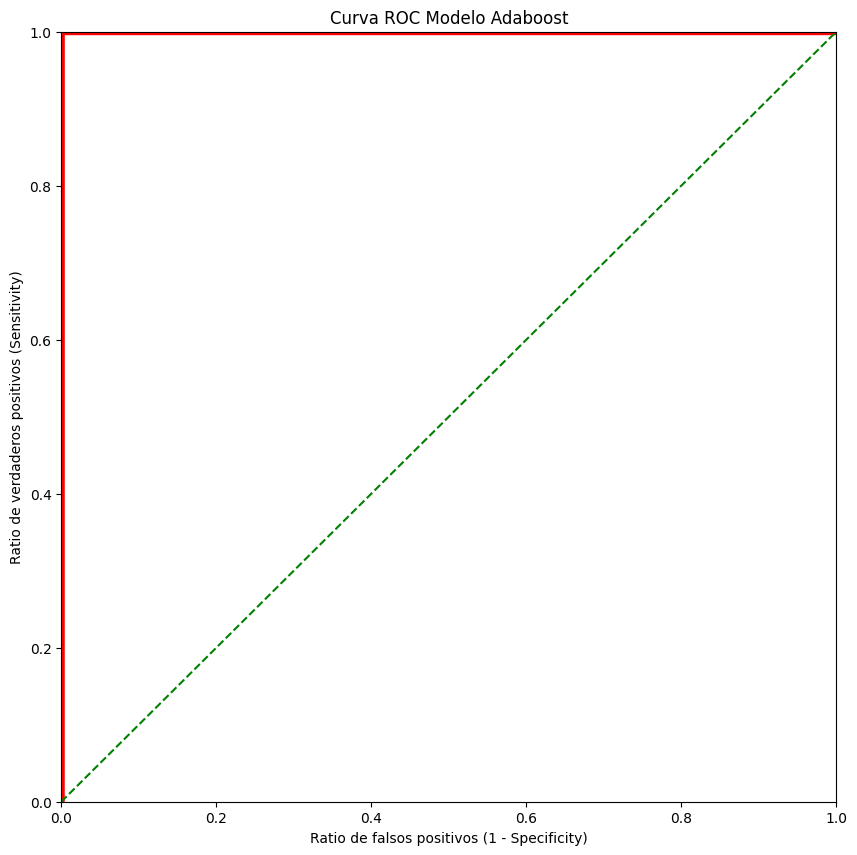

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,roc_auc_score
%matplotlib inline
fpr, tpr, thresholds = roc_curve(y_test, adaBoostModel.predict_proba(X_test)[:,1], drop_intermediate=False)
plt.figure(figsize=(10,10))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Curva ROC Modelo Adaboost')
plt.xlabel('Ratio de falsos positivos (1 - Specificity)')
plt.ylabel('Ratio de verdaderos positivos (Sensitivity)')
plt.plot(fpr, tpr, color='red', lw=5)
plt.plot([0,1], [0,1], 'g--') # diagonal
plt.show()

#### Gradient Tree Boosting (XGBoost)

In [ ]:

from xgboost import XGBClassifier

xgboostModel = XGBClassifier()
#xgboostModel = XGBClassifier()
xgboostModel.fit(X_train, y_train)
y_pred = xgboostModel.predict(X_test)


In [ ]:

from sklearn import metrics

xgboostModelAccuracy = metrics.accuracy_score(y_test, y_pred)

print("Random Forest Accuracy:", ramdomForestModelAccuracy)
print("Extra Trees Accuracy:", extraTreesModelAccuracy)
print("AdaBoost Accuracy:", adaBoostModelAccuracy)
print("XGBoost Accuracy:", xgboostModelAccuracy)


Random Forest Accuracy: 0.9678246484698098
Extra Trees Accuracy: 0.9882547559966914
AdaBoost Accuracy: 0.9999172870140612
XGBoost Accuracy: 0.9995864350703061


In [ ]:

from sklearn.metrics import confusion_matrix

confusion_matrix(y_pred, y_test)


array([[10329,     0],
       [    5,  1756]])

#### LightGBM

In [ ]:

from lightgbm import LGBMClassifier

lightgbmModel = LGBMClassifier()
lightgbmModel.fit(X_train, y_train)
y_pred = lightgbmModel.predict(X_test)


[LightGBM] [Info] Number of positive: 4068, number of negative: 24139
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1796
[LightGBM] [Info] Number of data points in the train set: 28207, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.144220 -> initscore=-1.780677
[LightGBM] [Info] Start training from score -1.780677


In [ ]:

from sklearn import metrics

lightgbmModelAccuracy = metrics.accuracy_score(y_test, y_pred)

print("Random Forest Accuracy:", ramdomForestModelAccuracy)
print("Extra Trees Accuracy:", extraTreesModelAccuracy)
print("AdaBoost Accuracy:", adaBoostModelAccuracy)
print("XGBoost Accuracy:", xgboostModelAccuracy)
print("LightGBM Accuracy:", lightgbmModelAccuracy)


Random Forest Accuracy: 0.9678246484698098
Extra Trees Accuracy: 0.9882547559966914
AdaBoost Accuracy: 0.9999172870140612
XGBoost Accuracy: 0.9995864350703061
LightGBM Accuracy: 0.9996691480562448


In [ ]:

from sklearn.metrics import confusion_matrix

confusion_matrix(y_pred, y_test)


array([[10330,     0],
       [    4,  1756]])

# Explicabilidad

#### AdaBoost **"Presenta los mejores resultados"**

In [ ]:

import numpy as np
from sklearn.inspection import permutation_importance
from matplotlib import pyplot

results = permutation_importance(adaBoostModel, X, y, scoring='accuracy')
importance_means = results.importances_mean


In [ ]:

columns = X.columns

features = []
importances = []
for i,v in enumerate(importance_means):
  if v > 0.0:
    features.append(columns[i])
    importances.append(v)
    print('Score: %.5f %s' %(v, columns[i]))


Score: 0.20465 Cancer
Score: 0.07919 Demenciadetcognitiu
Score: 0.17185 DM
Score: 0.02173 EnfVascular
Score: 0.00003 HTA
Score: 0.09842 MPOCAsmaBronq
Score: 0.00171 CHADs
Score: 0.45296 CHARLSON
Score: 0.00002 Wells
Score: 0.00004 Antiagregants
Score: 0.00001 Anticoagulants


In [ ]:
def sort_features_importances(features, importances):
    sorted_indices = sorted(range(len(importances)), key=lambda k: importances[k], reverse=True)
    sorted_features = [features[i] for i in sorted_indices]
    sorted_importances = [importances[i] for i in sorted_indices]
    return sorted_features, sorted_importances

In [ ]:
sorted_features, sorted_importances = sort_features_importances(features, importances)

In [ ]:
print("\nImportancia de las características según el modelo:")
for feature, importance in zip(sorted_features, sorted_importances):
    print('Porcentaje: %.5f %s' % (importance, feature))


Importancia de las características según el modelo:
Porcentaje: 0.45296 CHARLSON
Porcentaje: 0.20465 Cancer
Porcentaje: 0.17185 DM
Porcentaje: 0.09842 MPOCAsmaBronq
Porcentaje: 0.07919 Demenciadetcognitiu
Porcentaje: 0.02173 EnfVascular
Porcentaje: 0.00171 CHADs
Porcentaje: 0.00004 Antiagregants
Porcentaje: 0.00003 HTA
Porcentaje: 0.00002 Wells
Porcentaje: 0.00001 Anticoagulants


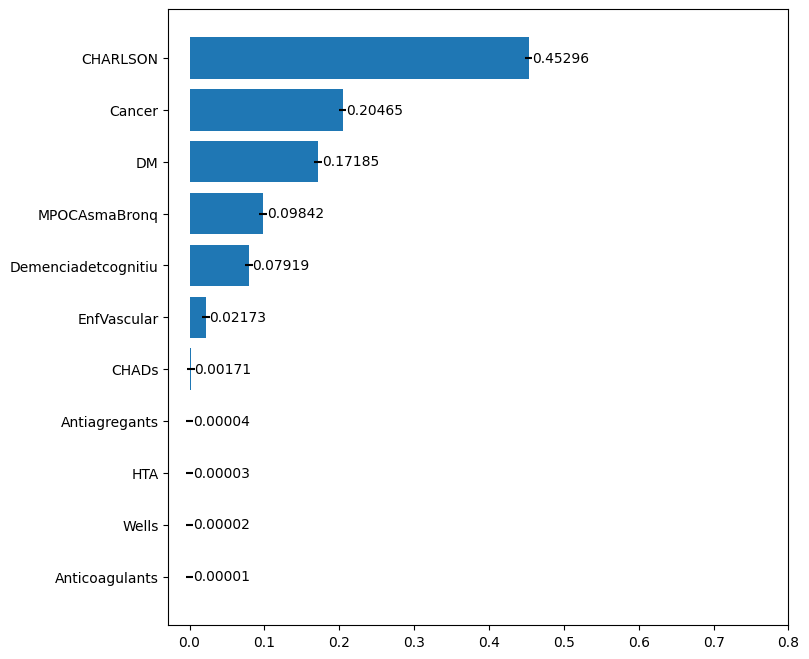

In [ ]:
sorted_features.reverse()
sorted_importances.reverse()

pyplot.figure(figsize=(8, 8))
xerror = np.full(shape=(len(sorted_features),),fill_value=0.005)
hbars = pyplot.barh(sorted_features, sorted_importances, xerr=xerror, align='center')
pyplot.bar_label(hbars, fmt='%.5f')
pyplot.xlim(right=0.8)
pyplot.show()


#### LightGBM - *Para poder explicar con Shapley* -
Adaboost no está soportado aún por Shapley, pero la importancia que el modelo LightGBM da a las características es muy similar.

In [ ]:

import numpy as np
from sklearn.inspection import permutation_importance
from matplotlib import pyplot

results = permutation_importance(lightgbmModel, X, y, scoring='accuracy')
importance_means = results.importances_mean


In [ ]:
columns = X.columns

features = []
importances = []
for i,v in enumerate(importance_means):
  if v > 0.0:
    features.append(columns[i])
    importances.append(v)


In [ ]:
sorted_features, sorted_importances = sort_features_importances(features, importances)

In [ ]:
print("\nImportancia de las características según el modelo:")
for feature, importance in zip(sorted_features, sorted_importances):
    print('Porcentaje: %.5f %s' % (importance, feature))


Importancia de las características según el modelo:
Porcentaje: 0.45177 CHARLSON
Porcentaje: 0.20542 Cancer
Porcentaje: 0.17163 DM
Porcentaje: 0.09783 MPOCAsmaBronq
Porcentaje: 0.07824 Demenciadetcognitiu
Porcentaje: 0.02140 EnfVascular
Porcentaje: 0.00002 ValorLinfo
Porcentaje: 0.00002 ValorFGlomerular


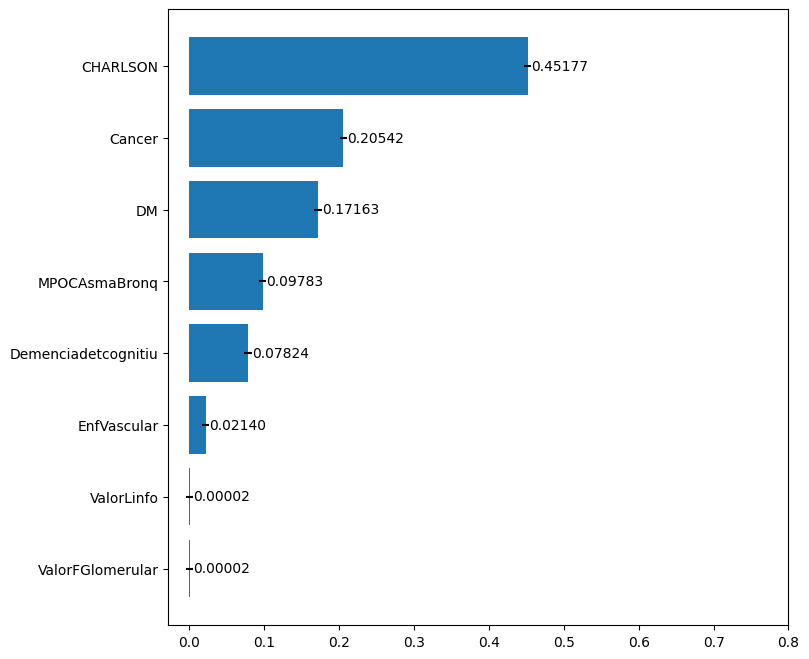

In [ ]:
sorted_features.reverse()
sorted_importances.reverse()

pyplot.figure(figsize=(8, 8))
xerror = np.full(shape=(len(features),),fill_value=0.005)
hbars = pyplot.barh(sorted_features, sorted_importances, xerr=xerror, align='center')
pyplot.bar_label(hbars, fmt='%.5f')
pyplot.xlim(right=0.8)
pyplot.show()


##### Explicabilidad con Shapley

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 7.8 MB/s eta 0:00:00


Explicabiidad de casos individuales con Shapley:

In [ ]:

import shap

tree_Explainer = shap.TreeExplainer(lightgbmModel, X_train)
shap_values = tree_Explainer.shap_values(X_test)

shap_vals = tree_Explainer.shap_values(X_test.iloc[0])


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
 98%|===================| 11841/12090 [00:38<00:00]       

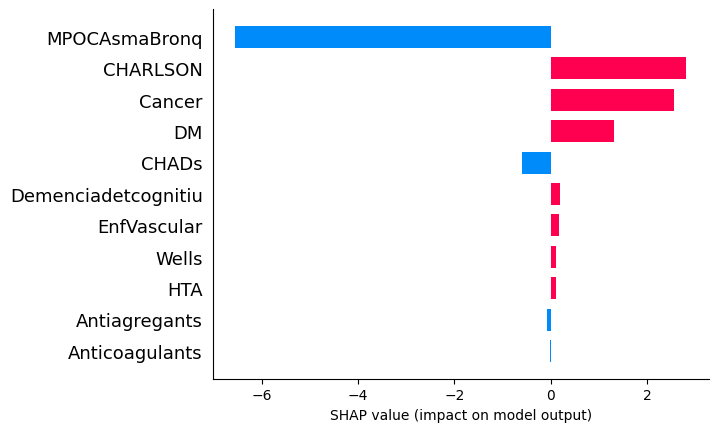

In [ ]:

shap.bar_plot(tree_Explainer.shap_values(X_test.iloc[10]),
              feature_names=X_test.columns,
              max_display = 11)


In [ ]:

shap.initjs()

shap.force_plot(tree_Explainer.expected_value,
                tree_Explainer.shap_values(X_test.iloc[12]),
                feature_names=X_test.columns,
                out_names=target[0]) # La etiqueta del objetivo.


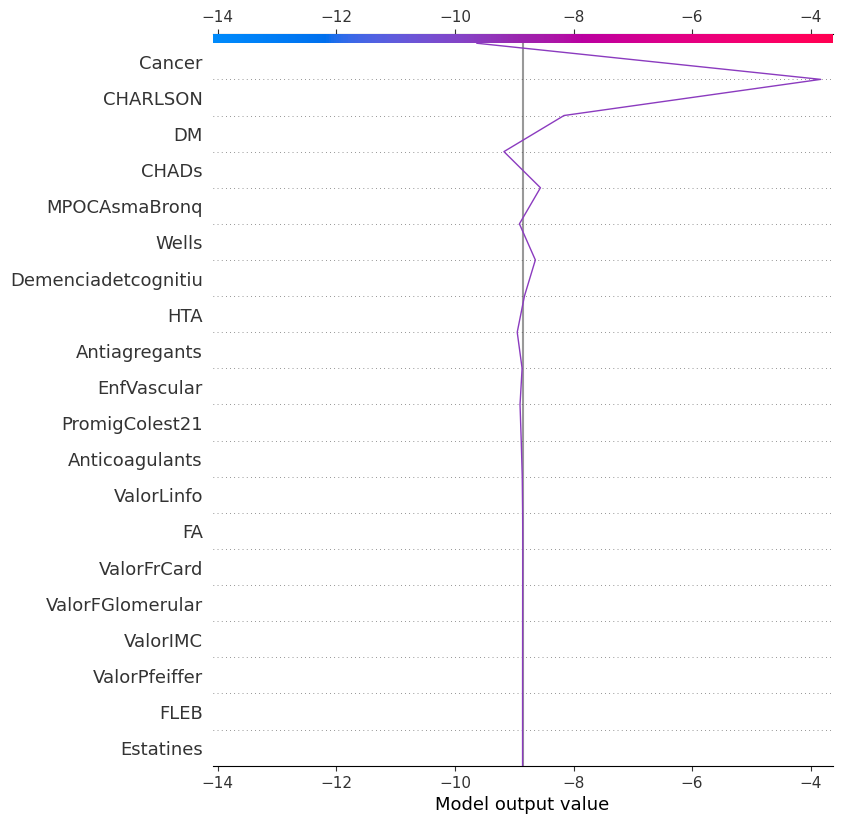

In [ ]:
shap.decision_plot(tree_Explainer.expected_value,
                   tree_Explainer.shap_values(X_test[0:1]),
                   feature_names=X_test.columns.values.tolist(),
                   )

Para un grupo de pacientes:


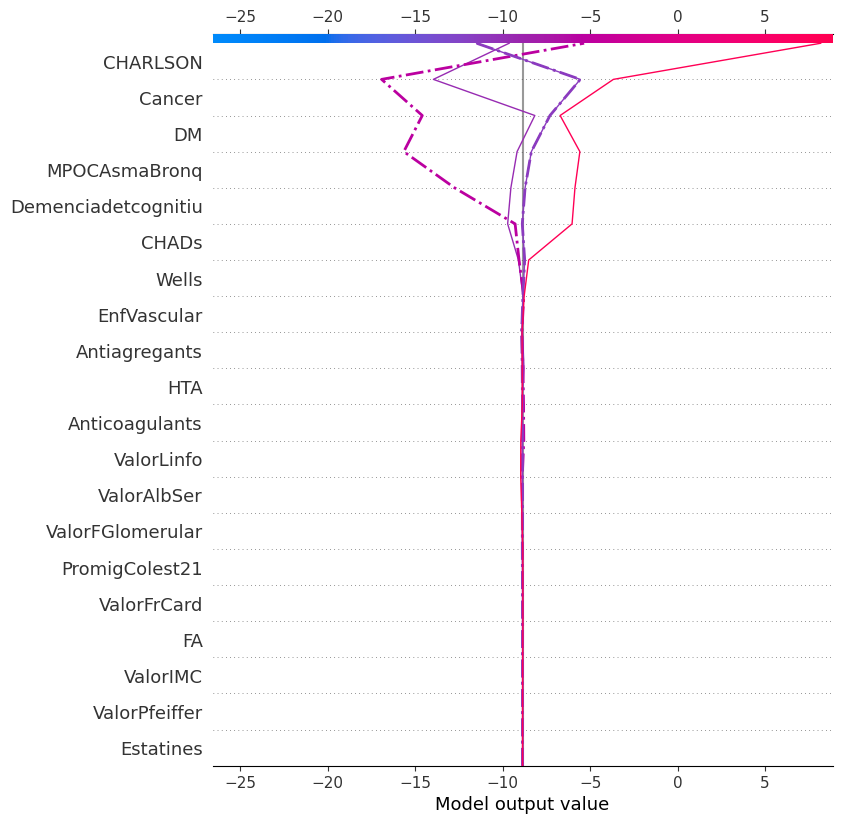

In [ ]:
shap.decision_plot(tree_Explainer.expected_value,
                   tree_Explainer.shap_values(X_test[0:5]),
                   feature_names=X_test.columns.values.tolist(),
                   highlight=[1, 2],
                   )

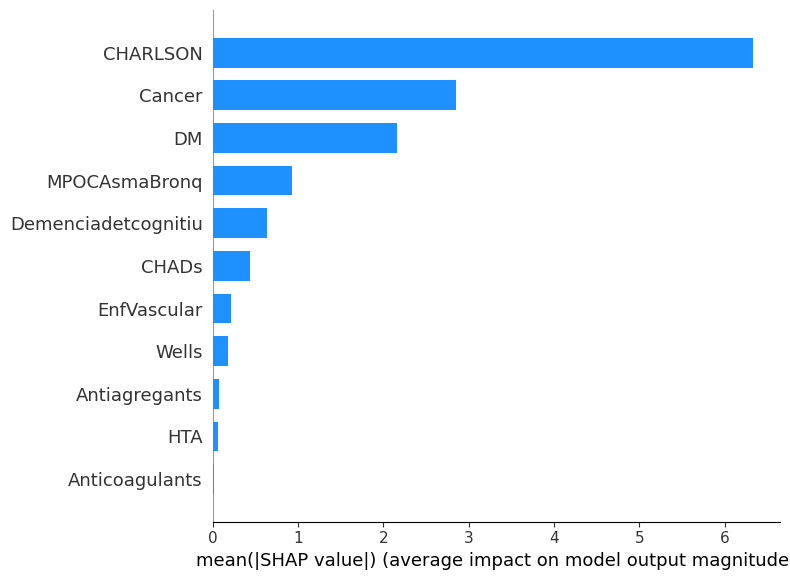

In [ ]:

shap.summary_plot(shap_values,
                  feature_names=X_test.columns,
                  plot_type="bar",
                  color="dodgerblue",
                  max_display=11
                  )


 99%|===================| 11979/12090 [00:43<00:00]       

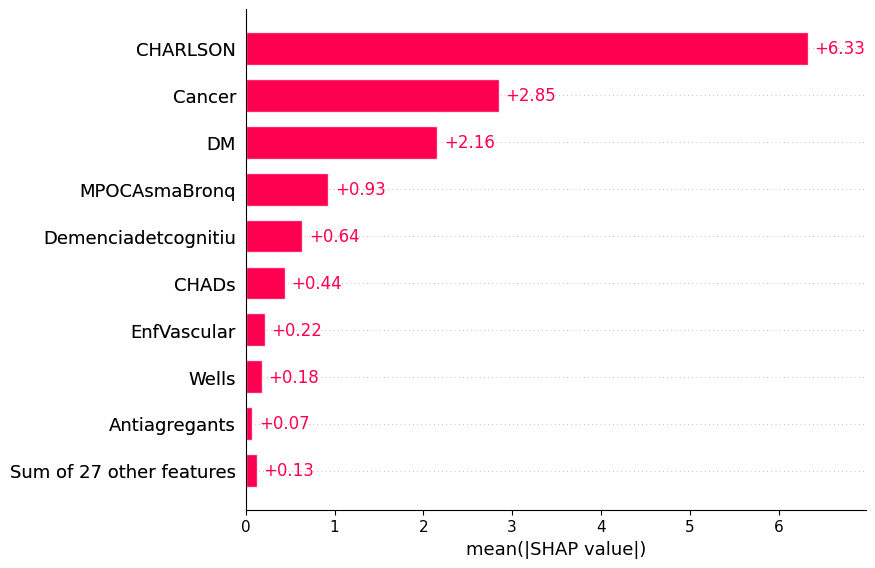

In [ ]:

shap.plots.bar(tree_Explainer(X_test), max_display=10)


 98%|===================| 11876/12090 [00:37<00:00]       No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


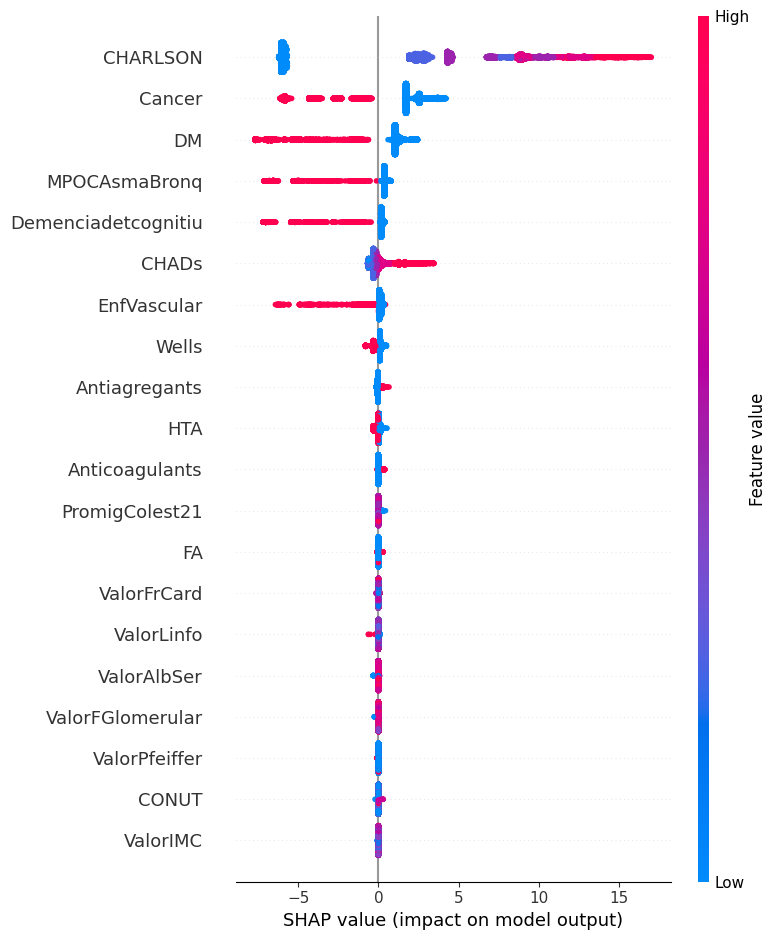

In [ ]:
shap.summary_plot(tree_Explainer.shap_values(X_test),
                  features = X_test,
                  feature_names=X_test.columns)